# Lab 6 - Principal Component Analysis

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction.\
You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.


## Example Dataset
To help you understand how PCA works, you will first start with a 2D dataset which has one direction of large variation and one of smaller variation.\
The script will plot the training data. In this part of the exercise, you will visualize what happens when you use PCA to reduce the data from 2D to 1D.

In practice, you might want to reduce data from 256 to 50 dimensions, say; but using lower dimensional data in this example allows us to visualize the algorithms better.

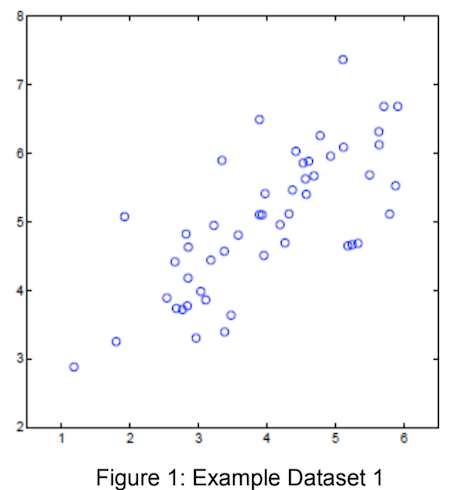

### Implementing PCA
In this part of the exercise, you will implement PCA. PCA consists of two computational steps:
1. **First:**\
You compute the covariance matrix of the data.
2. **Second:**\
You use Python's SVD function to compute the eigenvectors `U1, U2,...,Un.` These will correspond to the principal components of variation in the data.

In [1]:
## imports
#!jupyter nbconvert --to script *.ipynb
import pandas as pd
import numpy as np
from scipy.optimize import minimize ## if not installed, use conda install -c anaconda scipy
import matplotlib.pyplot as plt
import scipy.io 
%matplotlib inline


**NOTE**\
Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

**Remember:**
- Subtracting the mean from all data is equivalent to translating (moving) the data to be centered around the origin. This operation allows us to use the eigen vectors as transformation matrix to the normalized data directly without the usage of complex algebraic operations.

Well, the covariance equation requires it and finding the SVD of X works only because of that.

- Normalizing the features by their minimum-to-maximum values is to keep all features data within the same range to avoid skewed data reduction.\
 **For Example:** If building images contains two features; building area and building height (number of stories). You found out that the areas vary from 200-600 squared meters, but the height varies from 2-10 stories. the data will be very skewed (too much variations) in the area than it is in the height. we want to reduce this skew for better PCA analysis.


In [2]:
# TODO [1]: Fill the function featureNormalize(X) 3 lines

# X has dimentionsion MxN

def featureNormalize(X):        # this is actually standardization
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)          
    normalized_X = (X-mu)/sigma  
    # What's really needed is subtracting the mean (by the proof).
    # As the covariance equation requires it and finding the SVD of X works only because of that.
    # Dividing by sigma ensures that different features will be on the same scale.
    # Note that it's not always the case that we should do feature scaling.
    # https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance    
    return (normalized_X, mu, sigma)            #Now normalized_X has mean [0, 0, .., 0] and STD [1, 1, ...,1] 


After normalizing the data, you can run PCA to compute the principal components. You
task is to complete the code to compute the principal components of the dataset and
print these principal components.

In [3]:
# TODO [2]: Fill the function PCA(X) where X represents a given dataset. Each row in X represents a data point.
def pca(X):
    # First, we need to compute the covariance matrix of X. (Check np.cov)
    # If we're using SVD then we shouldn't.
    cov = X.T @ X/(X.shape[0] -1)       #Useless.
    # Second, we need to find the eigenvectors of this covariance matrix.
    # Agree. These can be found by applying SVD on X
    # Why do we want to calculate the eigenvectors for?
    # The eigenvectors will form a basis for the new space to which we will project the data.
    ## Hint: Check for the function np.linalg.svd. What does this function do? What does it return?
    # It returns the singular values and vectors of X.
    # A singular vector of X is either an eigenvalue of X@X^T(from U) ot X^T@X (from V) (covariance matrix)
    
    U, S, Vt = np.linalg.svd(X)     # The feature selection and projection steps are done in another function.
    
    #Replace None with the needed values returned from np.linalg.svd.
    #If you do not know which returned values are needed from this function, you can check where this function is called in this file. 
    # print(Vt.T, 'compare to U in the other formulation')
    return Vt.T, S/(X.shape[0] -1)                     # V has the directions and S has the variance corresponding to each.

    # We need V and not U because V (right singular vectors) correspond to eigenvectors of X.T @ X
    # which the eigenvectors of the covariance matrix X.T @ X /(X.shape[0] - 1)  
    # The SVD also gives us the eigenvalues of X.T @ X (or X @ X.T) in S which is the covariance multipled by (n - 1)
    # (assuming that we have n data points.) Recall that on scaling only the eigvenvalues get affected



In [4]:
### Test Your Implementation ###
np.random.seed(3)
test_features = np.random.random((10,2))
actual_features_mean = np.array([0.35502116, 0.50634598])
actual_features_sigma = np.array([0.29845715, 0.18951448])
actual_features_normalized = np.array([[ 0.65596265,  1.064836  ], [-0.21482622,  0.02364791], [ 1.8023552 ,  2.05761116],
                                  [-0.76873967, -1.57825993], [-1.01707718, -0.34581074], [-1.0894192 , -0.2612611 ], 
                                  [ 0.98547778, -1.20232873], [ 1.07631445,  0.44596504], [-1.10916853,  0.27706645], 
                                  [-0.32087927, -0.48146605]])

(test_features_normalized, test_features_mean, test_features_sigma) = featureNormalize(test_features)


## Assertions
normalization_truth = np.round(actual_features_normalized,2) == np.round(test_features_normalized,2)
assert normalization_truth.all() , "Incorrect feature normalization calculated"
mean_truth = np.round(test_features_mean, 2) == np.round(actual_features_mean,2)
assert mean_truth.all(), "Incorrect feature mean calculated"
sigma_truth =  np.round(test_features_sigma,2) == np.round(actual_features_sigma,2)
assert sigma_truth.all(), "Incorrect feature sigma calculated" 

## Dimensionality Reduction with PCA
After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space (e.g., projecting the data from 2D to 1D).\
In this part of the exercise, you will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional
space.

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input, thus avoiding the curse of dimensionality.

### Projecting the data onto the principal components
You should now complete the code in `projectData().`\
Specifically, you are given a dataset X, the principal components U, and the desired number of dimensions to reduce to K.\
You should project each example in X onto the top K components in U.

In [5]:
### NOTE: we assume that the previous steps were correct so that the assertion works

# TODO [3]: Fill the function projectData (X,U,K) (~1 line). Your code should be vectorized
def projectData(X, U, K):
    U_p = U[:,:K]             # Seleting K eigenvectors (ideally: according to sigma, we want to preserve the most variance.)
    Z = X @ U_p      
      
    return Z             

# Now for some reason when the other formulation was used (where we would use U instead of V) and X is a n x m matrix
# where n is the number of features and m is the data points the values we got where the additive inverse of these
# Update: It's solved. Check alternative formulation.

In [6]:
### Test Your Implementation ###
np.random.seed(3)
test_features = np.random.random((10,2))
test_u, test_s = pca(test_features)                # Its actually test v unless we use the other formulation...
z_test = projectData(test_features, test_u, 1)
z_actual = np.array([[-0.89662942], [-0.57867148], [-1.2601911 ], [-0.2396097 ], [-0.37161185],
                     [-0.37010177], [-0.62948026], [-0.88682734], [-0.44470977], [-0.48486548]])

z_truth = np.round(z_actual, 2) == np.round(z_test, 2)
assert z_truth.all(), "Incorrect projection"

## Reconstructing an approximation of the data
One of the cool things about PCA is that after projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space. Think of it as data compression technique without losing the important info. We want you to test it and validate that by yourselves!

Your task is to complete `recoverData()` to project each example in Z back onto the original space and return the recovered approximation in X.

In [7]:
# TODO [4]: Fill the function recoverData (Z, U, K) (~1 line). Check the dimensions.
def recoverData(Z, U, K):
    U_p = U[:,:K]
    X_rec = Z @ U_p.T
    return X_rec

In [8]:
### Test Your Implementation ###
np.random.seed(3)
test_features = np.random.random((10,2))
test_u, test_s = pca(test_features)
z_test = projectData(test_features, test_u, 1)

recovered_test = recoverData(z_test, test_u, 1)
recovered_actual = np.array([[0.57394047, 0.6888662 ], [0.37041277, 0.44458415], [0.80665955, 0.96818489], [0.1533763, 0.18408834], [0.23787205, 0.2855035 ],
                             [0.23690544, 0.28434334], [0.40293592, 0.48361973], [0.56766608, 0.68133542], [0.28466269, 0.34166349], [0.31036672, 0.37251448]])

recovery_truth = np.round(recovered_test, 2) == np.round(recovered_actual, 2)
assert recovery_truth.all(), "Incorrect recovering"


## Visualizing the projections
After completing both `projectData()` and `recoverData()`, the script will now perform both the projection and approximate reconstruction to show how the projection affects the data. The projection effectively only retains the information in the direction given by U1.


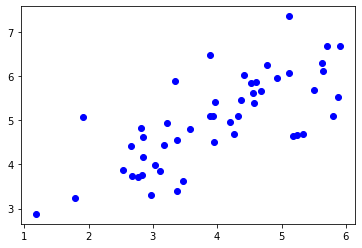

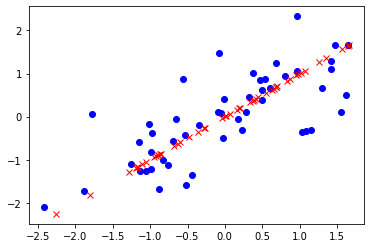

In [9]:
############ DONOT CHANGE CODE ############

def displayData(X):
    num_images = len(X)
    rows = int(num_images ** .5)
    cols = int(num_images ** .5)
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True)
    img_num = 0

    for i in range(rows):
        for j in range(cols):
            # Convert column vector into 32x232 pixel matrix
            #  transpose
            img = X[img_num, :].reshape(32, 32).T
            ax[i][j].imshow(img, cmap='gray')
            img_num += 1
    return (fig, ax)


raw_mat = scipy.io.loadmat("ex7data1.mat")
X = raw_mat.get("X")
plt.cla()
plt.plot(X[:, 0], X[:, 1], 'bo')
plt.show()

X_norm, mu, sigma = featureNormalize(X)
U, S = pca(X_norm)

K = 1
Z = projectData(X_norm, U, K)
X_rec = recoverData(Z, U, K)

plt.cla()
plt.plot(X_norm[:, 0], X_norm[:, 1], 'bo')
plt.plot(X_rec[:, 0], X_rec[:, 1], 'rx')
plt.show()

## Face Image Dataset
In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset ex7faces.mat contains a dataset X of face images, each `32x32` in grayscale. Each row of X corresponds to one face image (a row vector of length 1024). The next step in the script will load and visualize the first 100 of these face images.

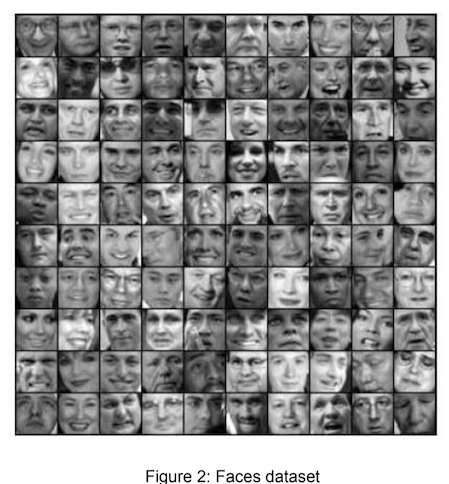

## PCA on Faces
To run PCA on the face dataset, we first normalize the dataset by subtracting the mean of each feature from the data matrix X. The script will do this for you and then run your PCA code. After running PCA, you will obtain the principal components of the dataset.

Notice that each principal component in U (each row) is a vector of length n (where for the face dataset, `n = 1024`). It turns out that we can visualize these principal components by reshaping each of them into a `32x32` matrix that corresponds to the pixels in the original dataset.\
The script displays the first 36 principal components that describe the largest variations. If you want, you can also change the code to display more principal components to see how they capture more and more details.




## Dimensionality Reduction
Now that you have computed the principal components for the face dataset, you can use it to reduce the dimension of the face dataset. This allows you to use your learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions. This can help speed up your learning algorithm.

The next part in the script will project the face dataset onto only the first 100 principal components. Concretely, each face image is now described by a vector of 100 dimensions.
To understand what is lost in the dimension reduction, you can recover the data using only the projected dataset. In the script, an approximate recovery of the data is performed and the original and projected face images are displayed side by side.


#### disclaimer 
*This lab is adopted from Stanford’s CS229 Andrew NG lecture notes.*

/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_3174/3932410590.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  face_grid.show()
/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_3174/3932410590.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  face_grid.show()


Done!


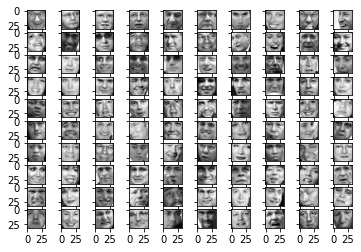

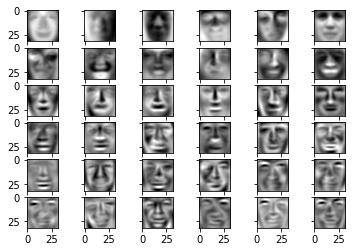

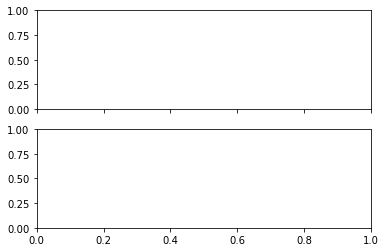

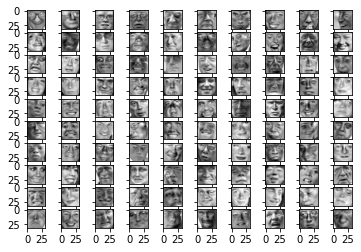

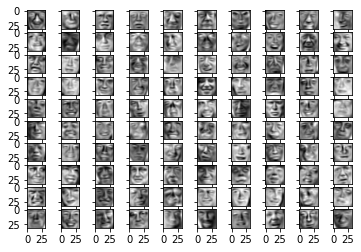

In [10]:
############ DONOT CHANGE CODE ############
############ IGNORE ANY WARNING ############          # Mashy.

# Loading and Visualizing Face Data
raw_mat = scipy.io.loadmat("ex7faces.mat")
X = raw_mat.get("X")
face_grid, ax = displayData(X[:100, :])
face_grid.show()

X_norm, mu, sigma = featureNormalize(X)
U, S = pca(X_norm)

face_grid, ax = displayData(U[:, :36].T)
face_grid.show()

# Dimension Reduction on Faces
K = 100
Z = projectData(X_norm, U, K)

# Visualization of Faces after PCA
K = 100
X_rec = recoverData(Z, U, K)

#plt.close()
#plt.cla()
f = plt.subplots(2, sharex=True, sharey=True)
f1, ax1 = displayData(X_norm[:100, :])             # This and the one below are generated as two separate images
f2, ax2 = displayData(X_rec[:100, :])              # rather than on the subplot


#f.show()
print("Done!")
